In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import itertools


In [3]:

DATA_DIR = "/kaggle/input/fruit-and-vegetable-image-recognition"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "validation")
TEST_DIR  = os.path.join(DATA_DIR, "test")

IMG_SIZE = (224, 224)
SEED = 42


gpus = tf.config.list_physical_devices('GPU')
print("GPUs found:", gpus)

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Using MirroredStrategy with {strategy.num_replicas_in_sync} replicas")
else:
    strategy = tf.distribute.get_strategy()  # default for 1 GPU / CPU
    print("Using default strategy (single device)")

BASE_BATCH_SIZE = 32
GLOBAL_BATCH_SIZE = BASE_BATCH_SIZE * strategy.num_replicas_in_sync
print("Global batch size:", GLOBAL_BATCH_SIZE)


GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using default strategy (single device)
Global batch size: 32


In [4]:

from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy:", mixed_precision.global_policy())


Mixed precision policy: <DTypePolicy "mixed_float16">


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_raw_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=GLOBAL_BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_raw_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=GLOBAL_BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

test_raw_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=GLOBAL_BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

class_names = train_raw_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("Number of classes:", num_classes)


Found 3115 files belonging to 36 classes.


I0000 00:00:1764089238.428362      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.
Classes: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
Number of classes: 36


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)

def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label

def preprocess(image, label):
    
    image = preprocess_input(image)
    return image, label


train_ds = (
    train_raw_ds
    .map(augment, num_parallel_calls=AUTOTUNE)
    .map(preprocess, num_parallel_calls=AUTOTUNE)
)

val_ds = val_raw_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_raw_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


train_ds = train_ds.ignore_errors()
val_ds   = val_ds.ignore_errors()
test_ds  = test_ds.ignore_errors()



In [7]:
with strategy.scope():
    
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,)
    )
    
   
    base_model.trainable = False

    inputs = keras.Input(shape=IMG_SIZE + (3,), name="input_image")

    
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dense(256, activation="relu", name="dense_relu")(x)
    x = layers.Dropout(0.4, name="dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32", name="predictions")(x)

    model = keras.Model(inputs, outputs, name="AgriVision_ResNet")

     
    initial_lr = 1e-3
    optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
    loss = keras.losses.SparseCategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"]
    )

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "AgriVision_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu (Dense)              │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,121,508 (92.02 MB)

 Trainable params: 533,796 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
checkpoint_path = "agrivision_resnet_best.keras"

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks = [early_stopping_cb, reduce_lr_cb, model_checkpoint_cb]


In [9]:
EPOCHS = 30

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)


Epoch 1/30


I0000 00:00:1764089271.564400     133 service.cc:148] XLA service 0x79f44c003950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764089271.567323     133 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764089273.974959     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


      3/Unknown 16s 52ms/step - accuracy: 0.0191 - loss: 4.5440   

I0000 00:00:1764089279.394705     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     98/Unknown 56s 418ms/step - accuracy: 0.3244 - loss: 2.6959

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.85755, saving model to agrivision_resnet_best.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 68s 540ms/step - accuracy: 0.3261 - loss: 2.6878 - val_accuracy: 0.8575 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 2/30
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7292 - loss: 0.8908
Epoch 2: val_accuracy improved from 0.85755 to 0.88034, saving model to agrivision_resnet_best.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - accuracy: 0.7295 - loss: 0.8898 - val_accuracy: 0.8803 - val_loss: 0.3129 - learning_rate: 0.0010
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7947 - loss: 0.6664
Epoch 3: val_accuracy improved from 0.88034 to 0.91453, saving model to agrivision_resnet_best.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 433ms/step - accuracy: 0.7948 - loss: 0.6661 - val_accuracy: 0.9145 - val_loss: 0.2790 - learning_rate: 0.0010
Epoch 4/30
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8177 - loss: 0.5690
Epoch 4: val_ac

In [10]:
FINE_TUNE_LAYERS = 20  

with strategy.scope():
    base_model.trainable = True

    
    for layer in base_model.layers[:-FINE_TUNE_LAYERS]:
        layer.trainable = False

    
    fine_tune_lr = 1e-4
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=fine_tune_lr),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

model.summary()

fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=callbacks
)


Model: "AgriVision_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu (Dense)              │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,121,508 (92.02 MB)

 Trainable params: 9,465,124 (36.11 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

Epoch 23/40
     98/Unknown 61s 417ms/step - accuracy: 0.9286 - loss: 0.1820
Epoch 23: val_accuracy did not improve from 0.97721
98/98 ━━━━━━━━━━━━━━━━━━━━ 70s 503ms/step - accuracy: 0.9285 - loss: 0.1822 - val_accuracy: 0.9601 - val_loss: 0.1738 - learning_rate: 1.0000e-04
Epoch 24/40
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9554 - loss: 0.1411
Epoch 24: val_accuracy did not improve from 0.97721
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 428ms/step - accuracy: 0.9553 - loss: 0.1414 - val_accuracy: 0.9744 - val_loss: 0.1325 - learning_rate: 1.0000e-04
Epoch 25/40
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9617 - loss: 0.1193
Epoch 25: val_accuracy did not improve from 0.97721
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 426ms/step - accuracy: 0.9617 - loss: 0.1193 - val_accuracy: 0.9715 - val_loss: 0.0993 - learning_rate: 1.0000e-04
Epoch 26/40
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9712 - loss: 0.0911
Epoch 26: val_accuracy did not improve from 0.97721
98/98 ━━━━━━━━━━

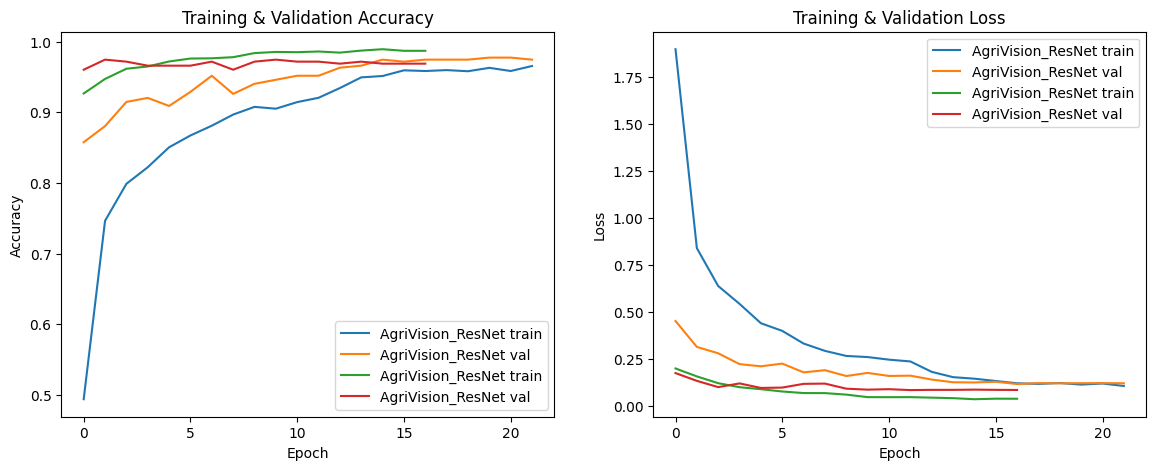

In [11]:
def plot_history(histories, keys=("accuracy", "loss")):
    plt.figure(figsize=(14, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    for h in histories:
        plt.plot(h.history["accuracy"], label=f"{h.model.name} train")
        plt.plot(h.history["val_accuracy"], label=f"{h.model.name} val")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for h in histories:
        plt.plot(h.history["loss"], label=f"{h.model.name} train")
        plt.plot(h.history["val_loss"], label=f"{h.model.name} val")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

histories_to_plot = [history]
if "history_fine" in globals():
    histories_to_plot.append(history_fine)

plot_history(histories_to_plot)


In [12]:
# Load the best saved model (.keras) based on val_accuracy
best_model = keras.models.load_model(checkpoint_path)
best_model.summary()

test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "AgriVision_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu (Dense)              │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,189,106 (96.09 MB)

 Trainable params: 533,796 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,067,598 (4.07 MB)

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step - accuracy: 0.9602 - loss: 0.1879
Test Loss: 0.1181
Test Accuracy: 0.9777


In [13]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"Macro F1-Score: {macro_f1:.4f}")


Classification Report:

               precision    recall  f1-score   support

        apple       0.82      0.90      0.86        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.83      1.00      0.91        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.80      0.89        10
       carrot       1.00      1.00      1.00        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       0.90      0.90      0.90        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00        10
     jalepeno       1.00      1.00      1.00        10
         kiwi       1.00      1.00      

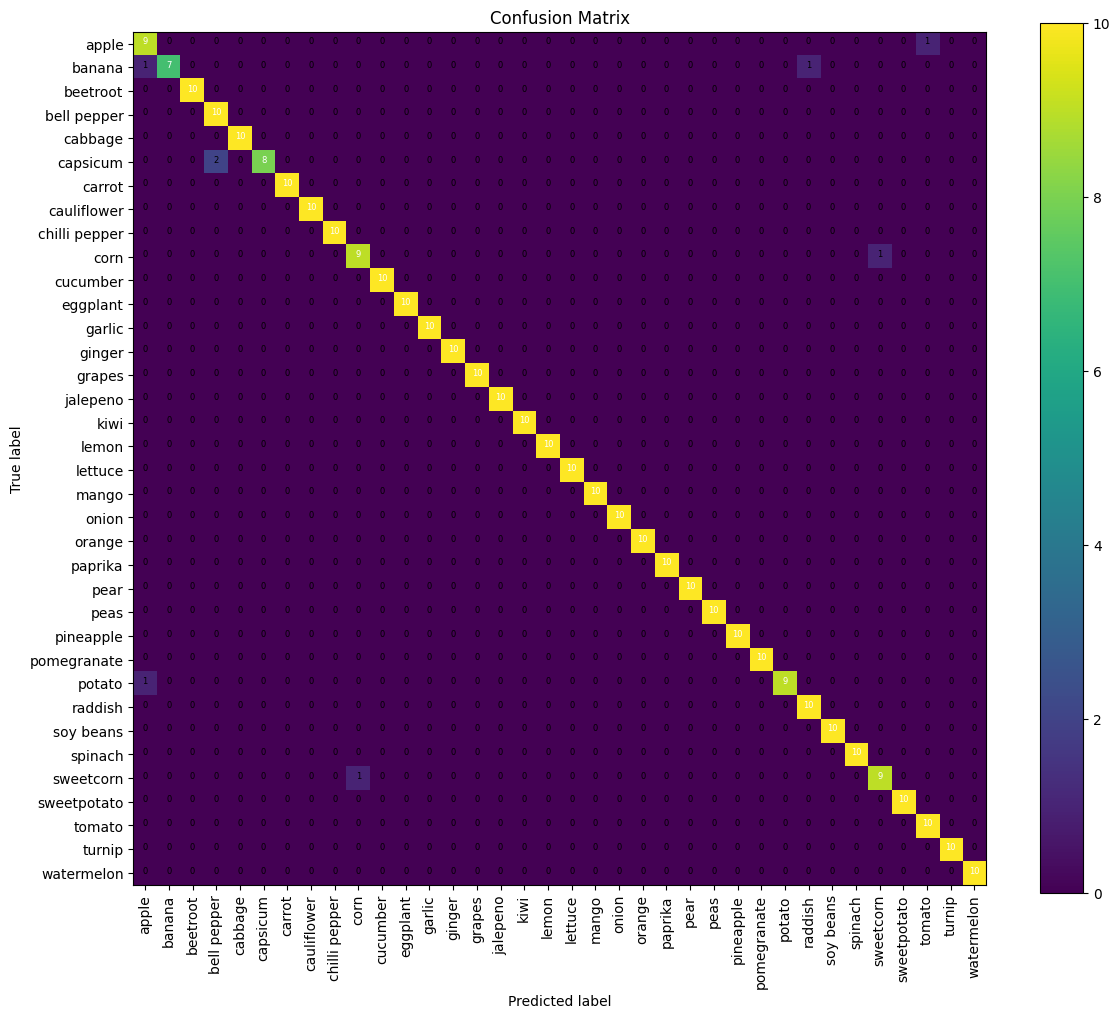

In [14]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
        fontsize=6
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


In [19]:
from IPython.display import display
import ipywidgets as widgets
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load your trained model
model = keras.models.load_model("agrivision_resnet_best.keras")

# File uploader widget
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False
)

output = widgets.Output()

def on_upload_change(change):
    with output:
        output.clear_output()
        
        if len(uploader.value) == 0:
            print("Upload an image first.")
            return
        
        # Kaggle gives a list of UploadedFile objects
        fileinfo = uploader.value[0]
        
        filename = fileinfo.name         # <-- correct for Kaggle
        content = fileinfo.content       # <-- correct for Kaggle
        
        save_path = os.path.join('/kaggle/working', filename)
        
        # Save file to working directory
        with open(save_path, 'wb') as f:
            f.write(content)
        
        print(f"File uploaded to: {save_path}")
        
        # Load + preprocess image
        img = load_img(save_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        # Predict
        preds = model.predict(img_array, verbose=0)[0]
        pred_idx = np.argmax(preds)
        pred_class = class_names[pred_idx]
        confidence = float(preds[pred_idx]) * 100
        
        print(f"\nPredicted Class: {pred_class}")
        print(f"Confidence: {confidence:.2f}%")

# Attach handler
uploader.observe(on_upload_change, names='value')

display(widgets.VBox([
    widgets.HTML("<b>Upload a fruit/vegetable image to classify:</b>"),
    uploader,
    output
]))


In [20]:
import json

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("Saved class_names.json")


Saved class_names.json
